In [48]:
import numpy as np
from scipy.linalg import expm

from functools import reduce

from qnl_projects.BHDecoder import qutrit_utils as qutils
from qnl_analysis import SimTools as ST

import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
def transformation_matrix(alpha_11, alpha_12, alpha_21, alpha_22):
    """ Returns the matrix representing the transformation between the times which each state spends in its 
    other states, and the phases attached to the states"""
    
    mat = np.matrix([[alpha_11, alpha_21, alpha_22, alpha_12],
                    [alpha_12, alpha_22, alpha_21, alpha_11],
                    [alpha_21, alpha_11, alpha_12, alpha_22],
                    [alpha_22, alpha_12, alpha_11, alpha_21]])

    return 2*np.pi*mat

In [50]:
Q0Q1_mat = transformation_matrix(alpha_11 = 0.27935, alpha_12 = -0.1599, alpha_21 = 0.52793, alpha_22 = 0.742967)

In [65]:
desired_phases = np.array([4*np.pi/3, 2*np.pi/3, 2*np.pi/3, 4*np.pi/3]) - 1*np.pi/180 * np.array([7.71877192, 2.88341957, 14.14030397, 15.30742407])

In [66]:
def possible_times(matrix_to_solve, desired_phases):
    for m1 in range(-10, 10):
        for m2 in range(-10, 10):
            for m3 in range(-10, 10):
                for m4 in range(-10, 10):
                    times = np.linalg.solve(matrix_to_solve, desired_phases+2*np.pi*np.array([m1, m2, m3, m4]))
                    if np.all(times > 0):
                        if np.sum(times) < 2:
                            print(times)

In [67]:
possible_times(Q0Q1_mat, desired_phases)

[0.56525053 0.09126357 0.61070513 0.09125475]


## Compensating for the phases acquired during Hadamard evolution

During the 80 ns the Hadamard takes (four 20 ns pulses each), we must get some phase evolution.  Let's see what the phases are, and if we can decompile them away.

In [54]:
alpha_11 = -0.27935 * 2*np.pi
alpha_12 = 0.1599 * 2*np.pi
alpha_21 = -0.52793 * 2*np.pi
alpha_22 = -0.742967 * 2*np.pi

H_zz = np.diag([0,0,0,0,alpha_11, alpha_12, 0, alpha_21, alpha_22])

In [55]:
Omega = 12.5*np.pi

H_X = Omega*np.array([[0,1,0],
                      [1,0,0],
                      [0,0,1]])

H_X_2q = np.kron(np.eye(3), H_X)

In [56]:
UX_2q = expm(1j*(H_X_2q + H_zz)*0.02)

In [57]:
qutrit_Hadamard_seq = qutils.qutrit_replacements['Hadamard'][1][0]

In [58]:
qutrit_Hadamard_seq

[['EFY-90'],
 ['X90'],
 ['Z-109.471'],
 ['EFZ54.7355'],
 ['X-90'],
 ['Z180'],
 ['EFZ-90'],
 ['EFY90']]

In [ ]:
Omega = 12.5 * np.pi # this is how we get a 20 ns pulse

HYEF = Omega * np.array([[0,0,0],[0,0,-1j],[0,1j,0]])
HX = Omega * np.array([[0,1,0], [1,0,0], [0,0,0]])
Id = np.eye(3)

pulse_time = 0.02 # in us, so 20 nanoseconds

HYEF_2q = np.kron(HYEF, Id)
HX_2q = np.kron(HX, Id)

UYEF = expm(-1j*pulse_time*(HYEF))
UYEF_m = expm(1j*pulse_time*(HYEF))
UX = expm(-1j*pulse_time*HX)
UX_m = expm(1j*pulse_time*HX)

UYEF_2q = expm(-1j*pulse_time*(HYEF_2q + H_zz))
UYEF_m_2q = expm(1j*pulse_time*(HYEF_2q + H_zz))
UX_2q = expm(-1j*pulse_time*(HX_2q + H_zz))
UX_m_2q = expm(1j*pulse_time*(HX_2q + H_zz))

Z1 = qutils.resulting_unitary([['Z-109.471']])
Z2 = qutils.resulting_unitary([['EFZ54.7355']])
Z3 = qutils.resulting_unitary([['Z180']])
Z4 = qutils.resulting_unitary([['EFZ-90']])

Z1_2q = np.kron(Z1, Id)
Z2_2q = np.kron(Z2, Id)
Z3_2q = np.kron(Z3, Id)
Z4_2q = np.kron(Z4, Id)

Hadamard_ideal = reduce(np.dot, reversed([UYEF_m, UX, Z1, Z2, UX_m, Z3, Z4, UYEF]))
Hadamard_ideal = Hadamard_ideal*np.exp(-1j*np.angle(Hadamard_ideal[0,0]))
Hadamard_ideal = np.kron(Hadamard_ideal, Id)

Hadamard_real = reduce(np.dot, reversed([UYEF_m_2q, UX_2q, Z1_2q, Z2_2q, UX_m_2q, Z3_2q, Z4_2q, UYEF_2q]))
Hadamard_real = Hadamard_real*np.exp(-1j*np.angle(Hadamard_real[0,0]))

In [ ]:
Hadamard_real

In [78]:
rho_init = np.array([[0,0,0,0,0,0,0,0,0],
                     [0,0,0,0,0,0,0,0,0],
                     [0,0,0,0,0,0,0,0,0],
                     [0,0,0,0,0,0,0,0,0],
                     [0,0,0,0,0,0,0,0,0],
                     [0,0,0,0,0,0,0,0,0],
                     [0,0,0,0,0,0,0,0,0],
                     [0,0,0,0,0,0,0,0,0],
                     [0,0,0,0,0,0,0,0,1],])

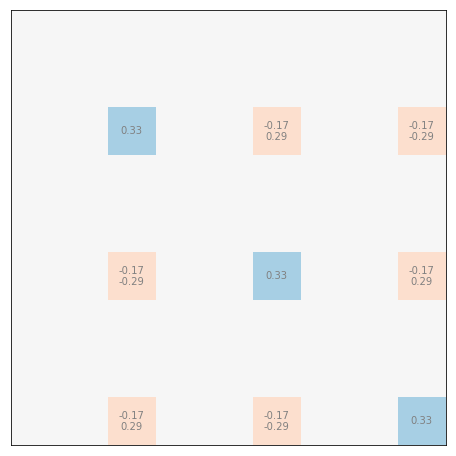

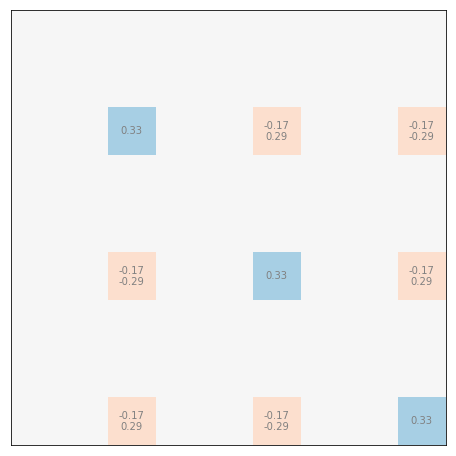

In [79]:
ST.plot_dm(reduce(np.dot, [Hadamard_ideal, rho_init, np.conj(Hadamard_ideal.T)]))

In [78]:
print(np.round((np.angle(Hadamard_ideal) - np.angle(Hadamard_real))*(180/np.pi), 3))

[[ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  1.800e+02 -0.000e+00
   0.000e+00  1.800e+02 -0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00 -0.000e+00  1.800e+02
   0.000e+00 -0.000e+00  1.800e+02]
 [ 0.000e+00  0.000e+00  0.000e+00 -9.000e-03  1.163e+00 -8.500e-01
   0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  1.800e+02 -0.000e+00 -1.163e+00 -1.100e-02 -2.011e+00
   0.000e+00  1.800e+02 -0.000e+00]
 [ 0.000e+00 -0.000e+00  1.800e+02  8.500e-01  2.015e+00  1.500e-02
   0.000e+00 -0.000e+00  1.800e+02]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
  -3.100e-02  1.170e+00  2.156e+00]
 [ 0.000e+00  1.800e+02 -0.000e+00  0.000e+00  1.800e+02 -0.000e+00
  -1.170e+00  5.000e-03  9.930e-01]
 [ 0.000e+00 -0.000e+00  1.800e+02  0.000e+00 -0.000e+00  1.800e+02
  -2.156e+00 -9.780e-01  1.100e-02]]


In [59]:
print(qutils.qutrit_mapping['Hadamard'])

[[ 0.57735027+0.j   0.57735027+0.j   0.57735027+0.j ]
 [ 0.57735027+0.j  -0.28867513+0.5j -0.28867513-0.5j]
 [ 0.57735027+0.j  -0.28867513-0.5j -0.28867513+0.5j]]


In [81]:
print(np.angle(UYEF_2q)*180/np.pi)

[[   0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]
 [   0.            0.          180.            0.            0.
     0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            2.44327455
  -179.56998       0.            0.            0.        ]
 [   0.            0.            0.            0.            0.43002
    -1.58323455    0.            0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.            0.            3.58958618 -175.4247708 ]
 [ 

In [86]:
HYEF_2q_q1 = np.kron(Id, HYEF)
HYEF_2q_q0 = np.kron(HYEF, Id)

UYEF_2q_q0 = expm(-1j*pulse_time*(HYEF_2q_q0 + H_zz))
UYEF_m_2q_q0 = expm(-1j*pulse_time*(-HYEF_2q_q0 + H_zz))
UYEF_2q_q1 = expm(-1j*pulse_time*(HYEF_2q_q1 + H_zz))
UYEF_m_2q_q1 = expm(-1j*pulse_time*(-HYEF_2q_q1 + H_zz))


np.angle(np.diag(reduce(np.dot, [UYEF_2q_q0, UYEF_2q_q1, UYEF_m_2q_q0, UYEF_m_2q_q1])))*180/np.pi

array([ 0.        ,  0.        ,  0.        ,  0.        ,  7.71877192,
        2.88341957,  0.        , 14.14030397, 15.30742407])